In [12]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib

from gpmdm import GPMDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

In [13]:
gpdm_save_name = "gpmdm"

In [14]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [15]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [16]:
d = 4 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [17]:
gpdm = GPMDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [18]:
for train_arr in walk_train_arrs[0:6]:
    gpdm.add_data(train_arr, 0)
for train_arr in run_train_arrs[0:6]:
    gpdm.add_data(train_arr, 1)

total_sequences = sum([len(L) for L in gpdm.class_aware_observations_list])
print(f"Total sequences: {total_sequences}")

Total sequences: 12



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.2301e+07
Update time: 0.34853053092956543

GPDM Opt. EPOCH: 10
Running loss: 3.5580e+06
Update time: 3.1444528102874756

GPDM Opt. EPOCH: 20
Running loss: 1.5702e+06
Update time: 3.235095262527466

GPDM Opt. EPOCH: 30
Running loss: 7.2858e+05
Update time: 3.0726537704467773

GPDM Opt. EPOCH: 40
Running loss: 3.3477e+05
Update time: 2.0137548446655273

GPDM Opt. EPOCH: 50
Running loss: 1.7794e+05
Update time: 2.087617874145508

GPDM Opt. EPOCH: 60
Running loss: 1.0554e+05
Update time: 2.1259868144989014

GPDM Opt. EPOCH: 70
Running loss: 7.8049e+04
Update time: 1.6866865158081055

GPDM Opt. EPOCH: 80
Running loss: 6.5282e+04
Update time: 1.7531218528747559

GPDM Opt. EPOCH: 90
Running loss: 5.6906e+04
Update time: 1.698556900024414

GPDM config dict saved in gpmdm_config.pth
GPDM state dict saved in gpmdm_state.pth


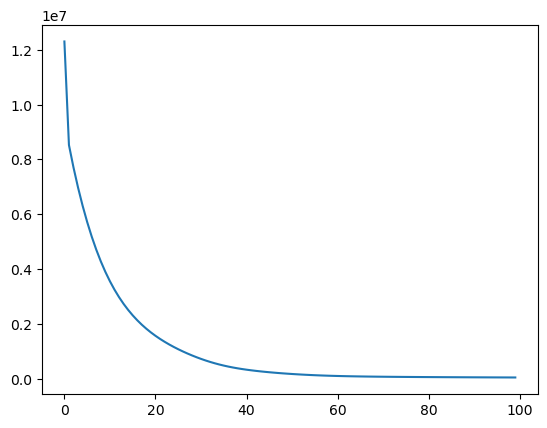

In [19]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=100, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

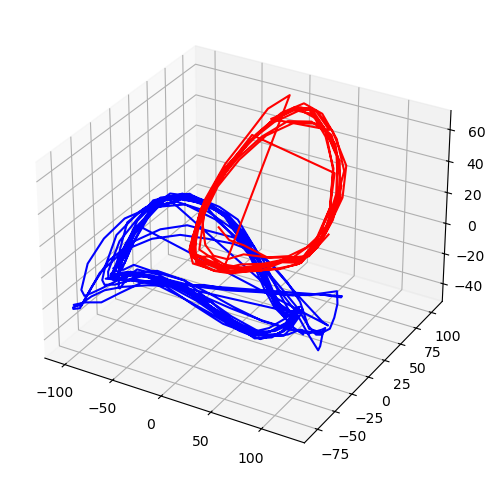

In [20]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()

In [21]:
gpdm.set_evaluation_mode()
_, _, _, latent_map_mse = gpdm.get_latent_map_performance()

print(f"Latent map MSE: {latent_map_mse}")

for i in range(gpdm.n_classes):
    _, _, _, _, dynamics_MSE = gpdm.get_dynamics_map_performance_for_class(i)
    print(f"Class {i} dynamics map MSE: {dynamics_MSE}")


Latent map MSE: 7.424317226890756
Class 0 dynamics map MSE: 180.46522556390977
Class 1 dynamics map MSE: 117.59727443609023


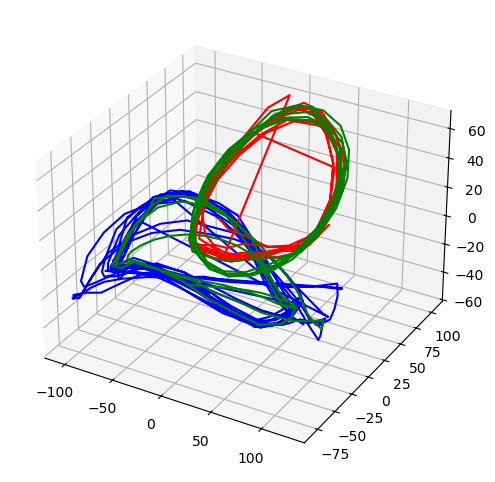

In [22]:
# For each class, pick a random point from the training latent space and generate a sequence

generated = []
for c in range(gpdm.n_classes):
    X0 = gpdm.get_X_for_class(c)
    X0_sample = X0[np.random.randint(X0.shape[0]), :]

    # Generate a sequence
    seq_len = 100
    X_generated = torch.zeros((seq_len, d))
    X_generated[0, :] = X0_sample
    for i in range(1, seq_len):
        X_generated[i, :], _ = gpdm.map_x_dynamics_for_class(X_generated[i-1, :].unsqueeze(0), c)

    generated.append(X_generated.detach().numpy())

# Plot the generated sequence in the latent space in green
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

for c in range(gpdm.n_classes):
    ax.plot(generated[c][:, 0], generated[c][:, 1], generated[c][:, 2], 'g')

    